## 工作流程基础

使用以往的数据，构建一个算法（网络）来发现一个模式，然后利用这个模式去预测未来

具体流程：
1. 自己构建数据或者导入其他数据
2. 构建模型、选择一个损失函数和一个优化器、进入训练loop
3. 预测新数据
4. 评估模型
5. 通过实验来提升
6. 存储或者加载刚才的到的模型

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.13.1'

## 1. 获取数据

- 将所有的需要去了解的都变为数字，图片、文本、语音等等
- 尽可能的去学习这些数字

In [3]:
# 自己创建数据

## 参数
weight = 0.7
bias = 0.3

## 构建输入的数据（特征）
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) ## 增加一个维度

## 获得输出的数据（标签）
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

####  把数据划分为训练集和测试集

- 训练集：用来学习，构建模型（相当于是日常学习）；数据量大约为 60%-80%；总是需要
- 验证集：用来检测，
- 测试集：用来最终检验这个模型是否有效（相当于是期末考试）；数据量大约是10%-20%；总是需要

In [4]:
# 将自己构建的数据集8、2分

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
# 图片、语音等转为数据；数据给机器看；数据再转成折线图等给人看

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14});

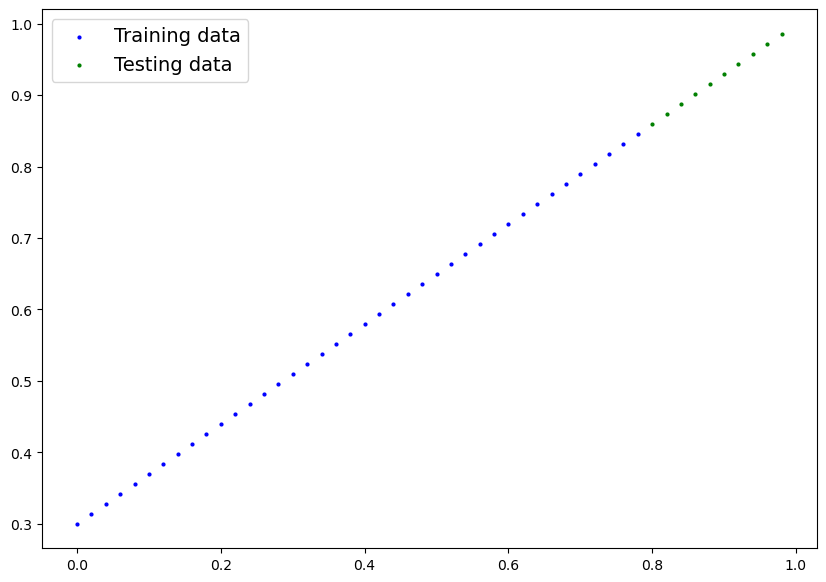

In [6]:
# 执行画图函数
plot_predictions()

## 2. 建造模型


In [7]:
# 构建一个线性模型

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
        self.bias = nn.Parameter(torch.randn(1, dtype = torch.float), requires_grad = True)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


In [8]:
# 查看模型对象有哪些内容

torch.manual_seed(42)

model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# 使用 torch.inference_mode()来进行预测

with torch.inference_mode():
    y_preds = model_0(X_test)


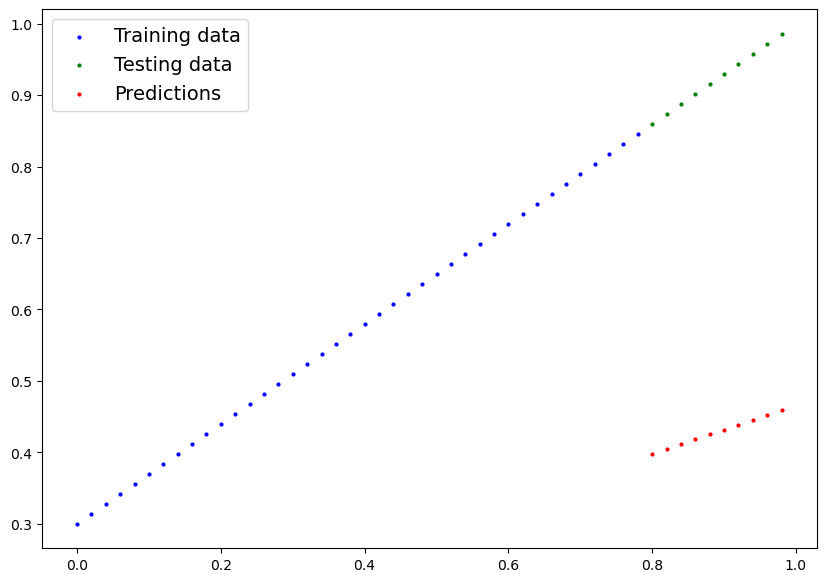

In [10]:
# 绘制y_preds的图片

plot_predictions(predictions=y_preds)

预测的结果相差甚远，是因为模型中的权重weights和偏置bias是正态分布随机给的，所以要对其进行训练。

1. 定义一个损失函数，也就是模型的输出和本应该的数据的差
2. 对这个参数进行优化

## 3. 训练模型

training loop的步骤和意义

1. 根据已有的参数，来得到输入的预测，所以定义forward函数
2. 比较预测的输入的数据之间的差，所以用损失函数loss_fn来刻画
3. 由于pytorch默认是记录梯度的，所以要对梯度置零
4. 进行反向传播来计算梯度，所以需要required_grad = True
5. 需要参数进一步优化，所以要使用优化器，使之往下走一小段距离

In [11]:
# 损失函数：torch.nn.L1Loss()、torch.nn.BCELoss()，用来衡量 y_preds 和 y_train 之间的错误值
# 优化器：torch.optim.SGD()、torch.nn.Adam()，用来优化weights、bias这样的参数
# 损失函数和优化器的选择需要根据问题类型来选择：回归问题或者分类问题
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.01)

In [16]:
torch.manual_seed(42)
epochs = 200

# 记录
train_loss_values = []
test_loss_values = []
epoch_count = []

# traning loop
for epoch in range(epochs):

    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
    

Epoch: 0 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 10 | MAE Train Loss: 0.021020207554101944 | MAE Test Loss: 0.04819049686193466 
Epoch: 20 | MAE Train Loss: 0.01758546568453312 | MAE Test Loss: 0.04060482233762741 
Epoch: 30 | MAE Train Loss: 0.014155393466353416 | MAE Test Loss: 0.03233227878808975 
Epoch: 40 | MAE Train Loss: 0.010716589167714119 | MAE Test Loss: 0.024059748277068138 
Epoch: 50 | MAE Train Loss: 0.0072835334576666355 | MAE Test Loss: 0.016474086791276932 
Epoch: 60 | MAE Train Loss: 0.0038517764769494534 | MAE Test Loss: 0.008201557211577892 
Epoch: 70 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 80 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 90 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 100 | MAE Train Loss: 0.008932482451200485 | MAE Test Loss: 0.005023092031478882 
Epoch: 110 | MAE Train Loss: 0.0089

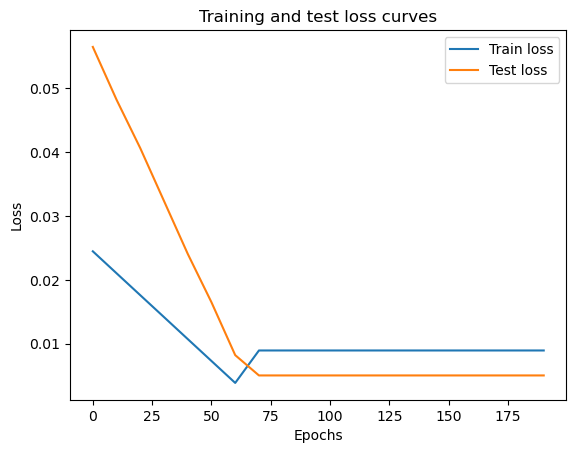

In [17]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [18]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4. 预测

使用训练好的模型进行预测

In [13]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)
    
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

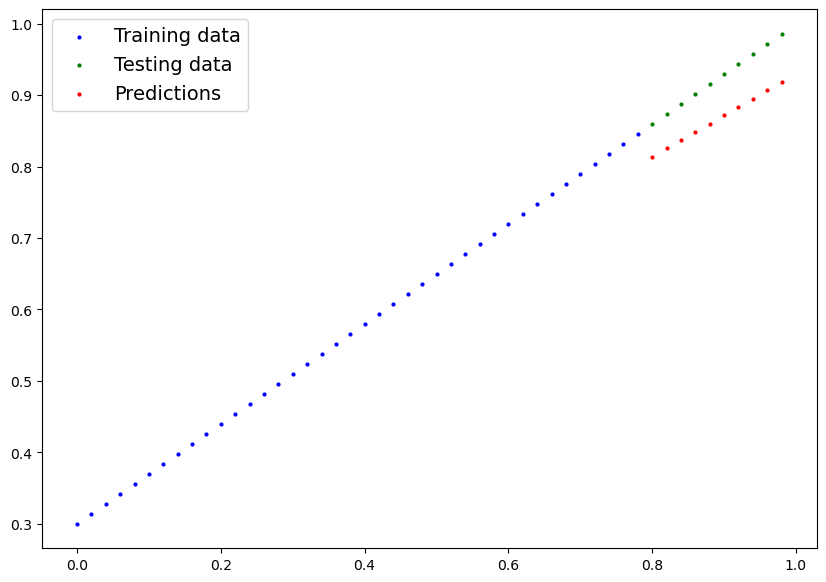

In [14]:
plot_predictions(predictions=y_preds)